<a href="https://colab.research.google.com/github/kmoy14-stanford/AA203-Homework/blob/master/HW2/AA_203_HW2_problem3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.integrate import odeint
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from tqdm import tqdm
import cvxpy as cvx

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp drive/MyDrive/animations.py .

# 4/1AY0e-g6gXzIIhdsgvyng2kNQV9-1V_Xio6l7fSI1pNpp1bYgd2Kvh7wYpzo yolo

from animations import animate_cartpole

Mounted at /content/drive


In [ ]:
@jax.partial(jax.jit, static_argnums=(0,))
def linearize(f, x, u):
    ###########################################################################
    # WRITE YOUR CODE HERE
    A, B = jax.jacfwd(f, (0,1))(x,u)
    c = f(x,u) - A@x - B@u
    ###########################################################################    
    return A, B, c

In [ ]:
def scp(f,Q,R,Q_N,s_star,s0,N,dt,rho,uLB,uUB):

    # Outer loop of scp.
    # Implement the inner loop in the function scp_iteration. 

    n = Q.shape[0] # state dimension
    m = R.shape[0] # control dimension
    eps = 0.01 # termination threshold for scp

    # initialize reference rollout s_bar,u_bar
    #u_bar = np.random.uniform(-3,3,(N,m))
    u_bar = np.zeros((N,m))

    s_bar = np.zeros((N+1,n))
    s_bar[0] = s0
    for k in range(N):
        s_bar[k+1] = f(s_bar[k],u_bar[k])


    # Compute new state and control via scp.
    s, u = scp_iteration(f,Q,R,Q_N,s_bar,u_bar,s_star,s0,N,dt,rho,uLB,uUB)

    # run scp until u converges
    round = 0
    while(np.linalg.norm(u-u_bar,np.inf) > eps):
        print("round: %s, u update: %s" % (round, np.linalg.norm(u-u_bar,np.inf)))
        round = round+1
        s_bar = s
        u_bar = u
        s,u = scp_iteration(f,Q,R,Q_N,s_bar,u_bar,s_star,s0,N,dt,rho,uLB,uUB)
    
    return s,u


In [ ]:
def scp_iteration(f,Q,R,Q_N,s_bar,u_bar,s_star,s0,N,dt,rho,uLB,uUB):

    ###########################################################################
    # WRITE YOUR CODE HERE
    # implement one iteration of scp
    # HINT: See slides 34-38 of Recitation 1. 
    n = Q.shape[0] # state dimension
    m = R.shape[0] # control dimension  
    # System dynamics
    A, B, c = jax.vmap(linearize, in_axes=(None, 0, 0))(f, s_bar[:-1], u_bar)
    A, B, c = np.array(A), np.array(B), np.array(c)
    # Initialize variables
    s = cvx.Variable((N+1, n))
    u = cvx.Variable((N, m))
    # Initialize cost, constraint forms
    cost = []
    cost.append(cvx.quad_form((s[N]-s_star), Q_N))
    constraints = []
    constraints.append(s[0] == s0)
    for k in range(N):
        cost.append(cvx.quad_form((s[k]-s_star), Q))
        cost.append(cvx.quad_form(u[k], R))
        # constraints.append(u[k] <= uUB)
        # constraints.append(u[k] >= uLB)
        constraints.append(s[k+1] == (A[k] @ (s[k])  + B[k] @ (u[k])  + c[k]))
        constraints.append(cvx.norm_inf(u[k] - u_bar[k]) <= rho)
        constraints.append(cvx.norm_inf(s[k] - s_bar[k]) <= rho)
    constraints.append(cvx.norm_inf(s[N] - s_bar[N]) <= rho)
    constraints.append(u <= uUB)
    constraints.append(u >= uLB)
    objective = cvx.Minimize(cvx.sum(cost))
    prob = cvx.Problem(objective, constraints)
    prob.solve()
    s_new, u_new = s.value, u.value

    ###########################################################################
    return s_new,u_new


In [ ]:
def cartpole(s, u):
    """Compute the cart-pole state derivative."""
    mp = 2.     # pendulum mass
    mc = 10.    # cart mass
    ℓ = 1.      # pendulum length
    g = 9.81    # gravitational acceleration

    x, θ, dx, dθ = s
    sinθ, cosθ = jnp.sin(θ), jnp.cos(θ)
    h = mc + mp*(sinθ**2)
    ds = jnp.array([
        dx,
        dθ,
        (mp*sinθ*(ℓ*(dθ**2) + g*cosθ) + u[0]) / h,
        -((mc + mp)*g*sinθ + mp*ℓ*(dθ**2)*sinθ*cosθ + u[0]*cosθ) / (h*ℓ)
    ])
    return ds

Computing SCP solution ... round: 0, u update: 0.5000007213824531
round: 1, u update: 0.5000007201397916
round: 2, u update: 0.5000002004061123
round: 3, u update: 0.5000007158651703
round: 4, u update: 0.5000006881799313
round: 5, u update: 0.22486294119295636
round: 6, u update: 0.3736077397163461
round: 7, u update: 0.5000008590009912
round: 8, u update: 0.5000001621901451
round: 9, u update: 0.5000012511130737
round: 10, u update: 0.500000019913956
round: 11, u update: 0.4999999297133837
round: 12, u update: 0.49999556253349553
round: 13, u update: 0.4999956475387991
round: 14, u update: 0.4999997044696604
round: 15, u update: 0.5001358021330718
round: 16, u update: 0.5000872334777398
round: 17, u update: 0.3252416863498342
round: 18, u update: 0.26312581752781816
round: 19, u update: 0.23742428285729278
round: 20, u update: 0.21868025767853405
round: 21, u update: 0.20423096014001696
round: 22, u update: 0.1956870613444816
round: 23, u update: 0.1988912535497261
round: 24, u updat

100%|██████████| 79/79 [00:00<00:00, 7978.57it/s]

done!
Simulating ...


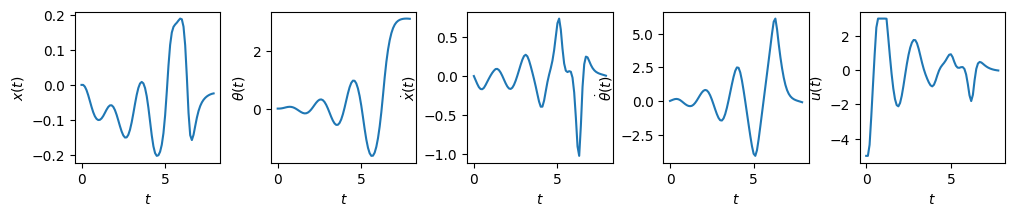

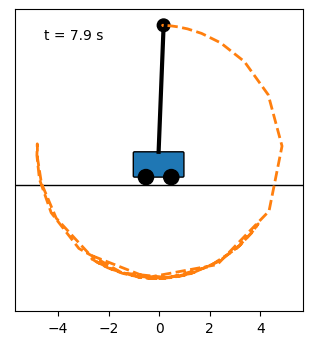

In [ ]:
if __name__ == '__main__':
    # cartpole swing-up simulation parameters
    n = 4                                   # state dimension
    m = 1                                   # control dimension 
    goal_state = np.array([0,np.pi,0,0])    # desired upright pendulum state
    start_state = np.array([0,0,0,0])       # initial downright pendulum state
    dt = 0.1                                # discrete time resolution
    T = 8                                   # total simulation time    

    # specify cost function
    Qf = 1000.*np.eye(4)                    # terminal state cost matrix
    Q = np.diag(np.array([10,10,2,2]))      # state cost matrix
    R = 2.5*np.eye(1)                       # control cost matrix

    # specify cartpole dynamics
    f = jax.jit(cartpole)
    f_discrete = jax.jit(lambda s, u, dt=dt: s + dt*f(s, u))

    # scp parameters 
    rho = 0.5                               # trust region parameter
    uLB = -5.                               # control effort lower bound
    uUB = 3.                                # control effort upper bound

    # solve swing-up with scp
    print('Computing SCP solution ... ', end='')
    t = np.arange(0., T, dt)                
    N = t.size - 1                          
    s,u = scp(f_discrete,Q,R,Qf,goal_state,start_state,N,dt,rho,uLB,uUB) # scp; yours to implement
    print('done!')

    print('Simulating ...')
    for k in tqdm(range(N)):
        s[k+1] = f_discrete(s[k],u[k])

    # Plot
    fig, axes = plt.subplots(1, n+1, dpi=100, figsize=(12, 2))
    plt.subplots_adjust(wspace=0.35)
    ylabels = (r'$x(t)$', r'$\theta(t)$',
               r'$\dot{x}(t)$', r'$\dot{\theta}(t)$', r'$u(t)$')
    for i in range(n):
        axes[i].plot(t, s[:, i])
        axes[i].set_xlabel(r'$t$')
        axes[i].set_ylabel(ylabels[i])
    axes[n].plot(t[0:N], u)
    axes[n].set_xlabel(r'$t$')
    axes[n].set_ylabel(ylabels[n])
    plt.savefig('cartpole_scp_swingup.pdf', bbox_inches='tight')
    plt.show()

    # animate the solution
    fig,ani = animate_cartpole(t, s[:,0], s[:,1])
    ani.save('cartpole_scp_swingup.mp4', writer='ffmpeg')